In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.12.0',
 'qiskit-aer': '0.4.1',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.5.0',
 'qiskit-aqua': '0.6.5',
 'qiskit': '0.16.2'}

In [2]:
# initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np

In [3]:
# import qiskit
from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_histogram

In [4]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

groverCircuit = QuantumCircuit(qr, cr)

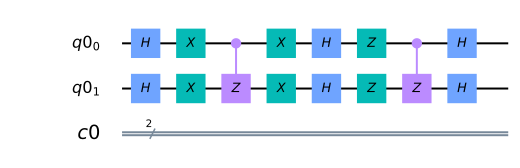

In [5]:
# initialize
groverCircuit.h(qr)

# oracle gate
groverCircuit.x(qr)
groverCircuit.cz(qr[0], qr[1])
groverCircuit.x(qr)

# Hadamard
groverCircuit.h(qr)

# reflection U_s
groverCircuit.z(qr)
groverCircuit.cz(qr[0], qr[1])

# Hadamard
groverCircuit.h(qr)

# Draw circuit
groverCircuit.draw(output='mpl')

In [6]:
# Now that we have circuit, use simulator
backend_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(groverCircuit, backend_sim)
statevec = job_sim.result().get_statevector()
print(statevec)

[ 1.00000000e+00-2.44929360e-16j -1.57009246e-16+4.79367020e-32j
 -2.22044605e-16+3.69778549e-32j -1.57009246e-16+2.17894100e-32j]


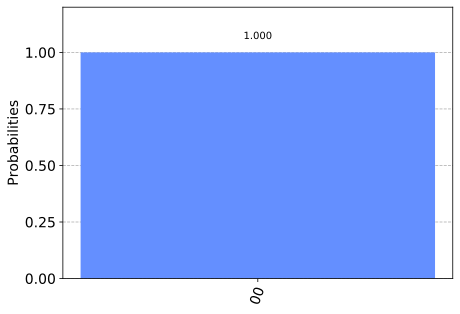

In [7]:
# measure state and create histogram from results
groverCircuit.measure(qr, cr)

backend = BasicAer.get_backend('qasm_simulator')
results = execute(groverCircuit, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

In [8]:
# run circuit on real quantum hardware

In [9]:
# load IBMQ account 
provider = IBMQ.load_account()
device = least_busy(provider.backends(simulator=False))
print('Running on current least busy device: ', device)

Running on current least busy device:  ibmq_london


In [10]:
# run circuit and monitor task
from qiskit.tools.monitor import job_monitor
job = execute(groverCircuit, backend=device, shots=1024, max_credits=10)
job_monitor(job, interval=2)

Job Status: job has successfully run


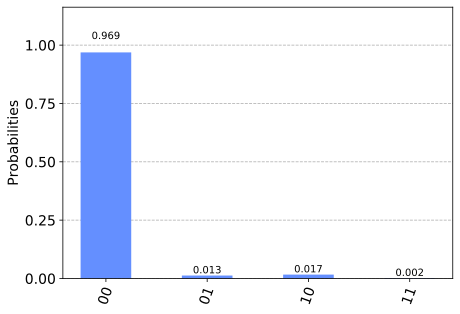

In [11]:
# results
results = job.result()
answer = results.get_counts(groverCircuit)
plot_histogram(answer)

In [12]:
# Grover's Algorithm for 3 qubits

In [13]:
def phase_oracle(circuit, register):
    """create phase oracle"""
    circuit.cz(qr[2], qr[0])
    circuit.cz(qr[2], qr[1])

In [14]:
def n_controlled_Z(circuit, controls, target):
    """implement Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)

In [15]:
def inversion_about_average(circuit, register, n, barriers):
    """apply inversion about the average step of Grover's algorithm"""
    circuit.h(register)
    circuit.x(register)
    
    if barriers:
        circuit.barrier()
        
        n_controlled_Z(circuit, [register[j] for j in range(n-1)], register[n-1])
        
    if barriers:
        circuit.barrier()
        
    circuit.x(register)
    circuit.h(register)

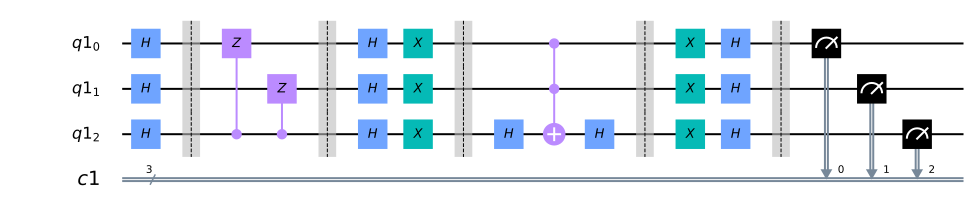

In [16]:
# build circuit
barriers = True 

qr = QuantumRegister(3)
cr = ClassicalRegister(3)

groverCircuit = QuantumCircuit(qr, cr)
groverCircuit.h(qr)

if barriers:
    groverCircuit.barrier()
    
phase_oracle(groverCircuit, qr)

if barriers:
    groverCircuit.barrier()
    
inversion_about_average(groverCircuit, qr, 3, barriers)

if barriers:
    groverCircuit.barrier()
    
groverCircuit.measure(qr, cr)
groverCircuit.draw(output='mpl')

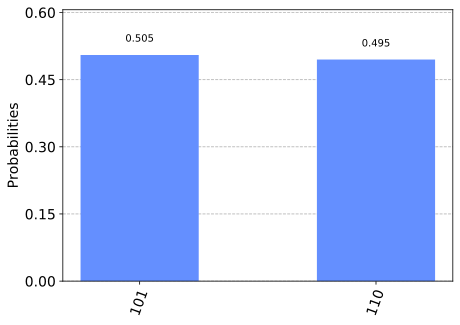

In [22]:
# run circuit on simulator

backend = BasicAer.get_backend('qasm_simulator')
results = execute(groverCircuit, backend=backend, shots=8192).result()
answer = results.get_counts()
plot_histogram(answer)

In [25]:
# run circuit on real quantum hardware

real_backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and
                                            not x.configuration().simulator 
                                            and x.status().operational == True))
print('least busy backend: ', real_backend)

least busy backend:  ibmq_london


In [26]:
from qiskit.tools.monitor import job_monitor

job = execute(groverCircuit, backend=real_backend, shots=2048)

job_monitor(job, interval=2)

Job Status: job has successfully run


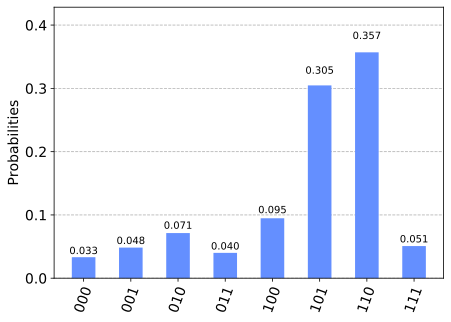

In [27]:
# results
results = job.result()
answer = results.get_counts(groverCircuit)
plot_histogram(answer)